# Influence function estimation at Univerity of Iowa
xchong@lbl.gov, 16th July 2024
awojdyla@lbl.gov

we apply 10V to each cell and then get the influence function after post-processing

In [1]:
# load the influence funtion from file
import numpy as np
import scipy.io as sc
import matplotlib.pyplot as plt  
import math


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# 1 extract the influence function from the npy files

In [4]:
#load the data
#data collection: apply 10V to each cell, record the results
ifs_file_name = "./onecell/seg3A_cells_1-16_ifs.npy"
influence_waves_3D_pV = np.load(ifs_file_name)

voltMaps_filename = "./onecell/seg3A_cells_1-16_voltMaps.npy"
voltMaps_V = np.load(voltMaps_filename)
print(influence_waves_3D_pV.shape,voltMaps_V.shape)

(16, 355, 1664) (16, 16)


Text(0, 0.5, 'k-th measurement')

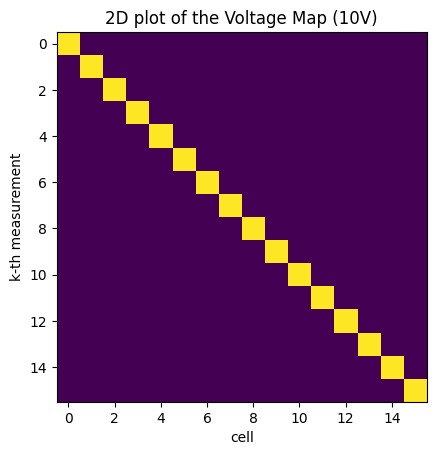

In [5]:
#plot the voltage map
plt.imshow(voltMaps_V)
plt.title("2D plot of the Voltage Map (10V)")
plt.xlabel("cell")
plt.ylabel("k-th measurement")

Text(0, 0.5, 'y-axis position (mm)')

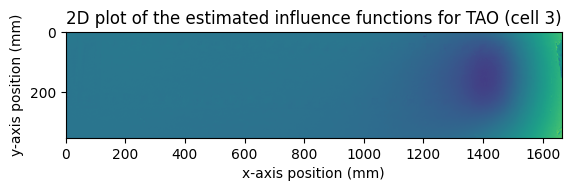

In [6]:
#2D plot of cell 3
plt.imshow(influence_waves_3D_pV[2,:,:])
plt.title("2D plot of the estimated influence functions for TAO (cell 3)")
plt.xlabel("x-axis position (mm)")
plt.ylabel("y-axis position (mm)")

Text(0, 0.5, '(um/10V)')

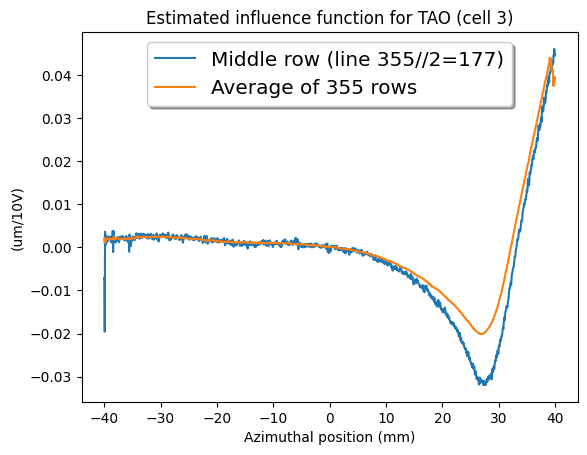

In [7]:
#1D plot of cell 3
fig,ax = plt.subplots()
cell_num = 2
xaxis = np.linspace(-40,40,influence_waves_3D_pV.shape[2])
yaxis = influence_waves_3D_pV[cell_num,177,:]
yaxis_avg = np.mean(influence_waves_3D_pV[cell_num,:,:], axis = 0)

plt.plot(xaxis,yaxis,label='Middle row (line 355//2=177)')
plt.plot(xaxis,yaxis_avg,label='Average of 355 rows')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')


plt.title("Estimated influence function for TAO (cell 3)")
ax.set_xlabel("Azimuthal position (mm)")
ax.set_ylabel("(um/10V)")

Text(0, 0.5, '(um/10V)')

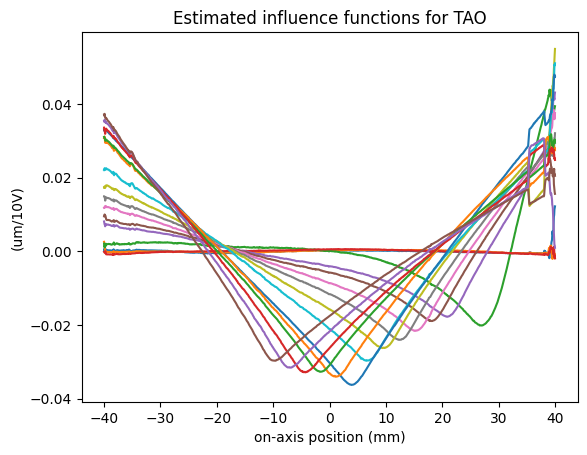

In [8]:
# plot the raw data, which contains artifcats due to the rectangular
fig,ax = plt.subplots()
xaxis = np.linspace(-40,40,influence_waves_3D_pV.shape[2])
for i in range(influence_waves_3D_pV.shape[0]):
    #calculate the average of the all rows     
    each_yaxis_avg = np.mean(influence_waves_3D_pV[i,:,:], axis = 0)
    plt.plot(xaxis,each_yaxis_avg)

plt.title("Estimated influence functions for TAO")
plt.xlabel("on-axis position (mm)")
plt.ylabel("(um/10V)")

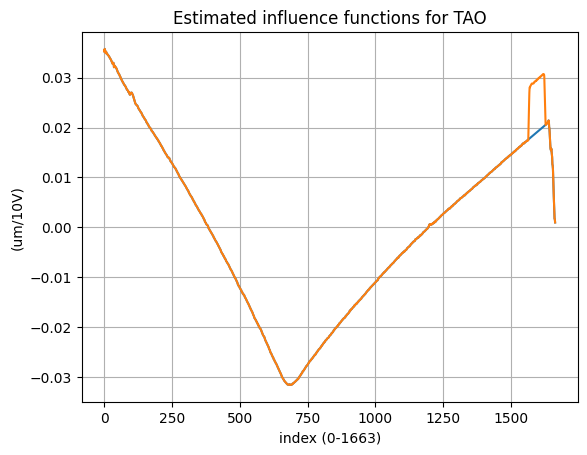

In [9]:
# interpolate the data to remove the artifacts
each_yaxis_avg = np.mean(influence_waves_3D_pV[14,:,:], axis = 0)
data_cleaned = each_yaxis_avg
idx = np.arange(len(each_yaxis_avg))
mask =  (idx<1560) | (idx>1630)
data_cleaned=np.interp(idx,idx[mask],each_yaxis_avg[mask])

plt.plot(data_cleaned)
plt.plot(each_yaxis_avg)
plt.xlabel("index (0-1663)")
plt.ylabel("(um/10V)")
plt.title("Estimated influence functions for TAO")  
plt.grid()
plt.show()

Text(0, 0.5, '(um/10V)')

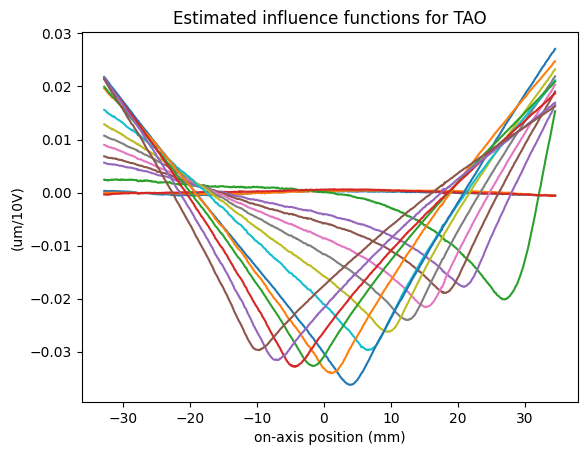

In [41]:
#plot the influence functions after interpolation and cropping
fig,ax = plt.subplots()
xaxis = np.linspace(-40,40,influence_waves_3D_pV.shape[2])
interp_start = 1560
interp_end = 1630

crop_start = 150
crop_end = 1590
influence_waves_pV=[]
for i in range(influence_waves_3D_pV.shape[0]):
    #calculate the average of the all rows     
    each_yaxis_avg_um = np.mean(influence_waves_3D_pV[i,:,:], axis = 0)

    # interpolate the values between the start and end
    idx = np.arange(len(each_yaxis_avg_um))
    mask =  (idx<interp_start) | (idx>interp_end)
    data_cleaned_um = np.interp(idx,idx[mask],each_yaxis_avg_um[mask])

    #remove the leftmost and rightmost points
    influence_waves_pV.append(data_cleaned_um[crop_start:crop_end])
    plt.plot(xaxis[crop_start:crop_end],data_cleaned_um[crop_start:crop_end])
influence_waves_umpV = np.array(influence_waves_pV).transpose((1,0))/10
plt.title("Estimated influence functions for TAO")
plt.xlabel("on-axis position (mm)")
plt.ylabel("(um/10V)")

# 2 find input voltage for a target wavefront

(1400, 18)


Text(0, 0.5, '(um/1V)')

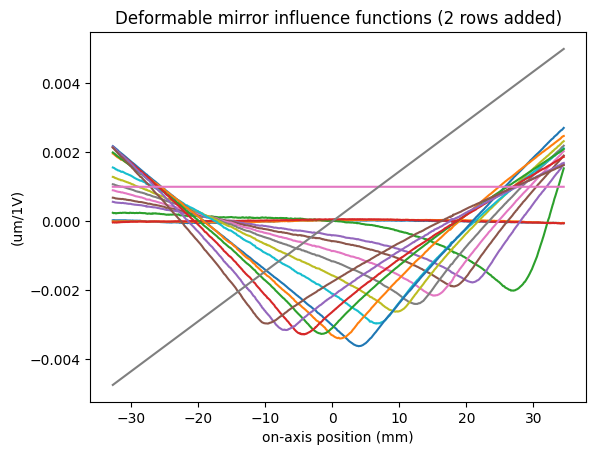

In [42]:
# add two rows to the influence function
y_mm = np.linspace(-40,40,influence_waves_3D_pV.shape[2])
y_mm = y_mm[crop_start:crop_end]
y_mm = np.expand_dims(y_mm, axis=1)


a,b = np.shape(influence_waves_umpV)
row1 = np.zeros((a,1))+0.001
row2 = y_mm/np.max(y_mm)*0.005


influence_waves_extend_umpV = np.concatenate((influence_waves_umpV,row1),axis=1)
influence_waves_extend_umpV = np.concatenate((influence_waves_extend_umpV,row2),axis=1)

np.save("seg3A_cells_1-18_ifs", influence_waves_extend_umpV)
print(influence_waves_extend_umpV.shape)

plt.plot(y_mm, influence_waves_extend_umpV)
plt.title("Deformable mirror influence functions (2 rows added)")
plt.xlabel("on-axis position (mm)")
plt.ylabel("(um/1V)")

Text(0, 0.5, 'Wavefront (nm)')

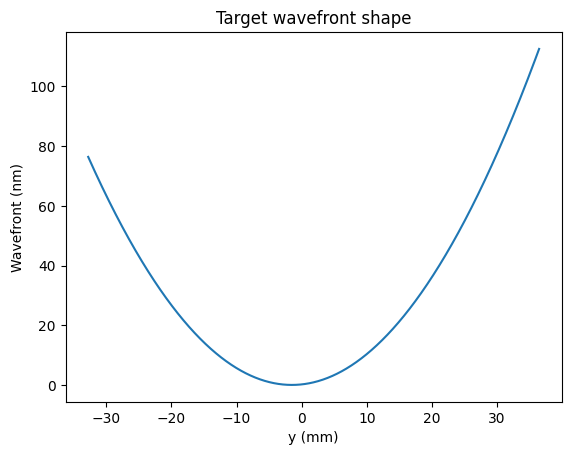

In [12]:
#define a target wavefront shape
target_shape_m = (((idx-800)/np.max(idx))**2)*100e-9*5
wavefront_w = target_shape_m[crop_start:crop_end]

plt.plot(y_mm,wavefront_w*1e9)
plt.title("Target wavefront shape")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")

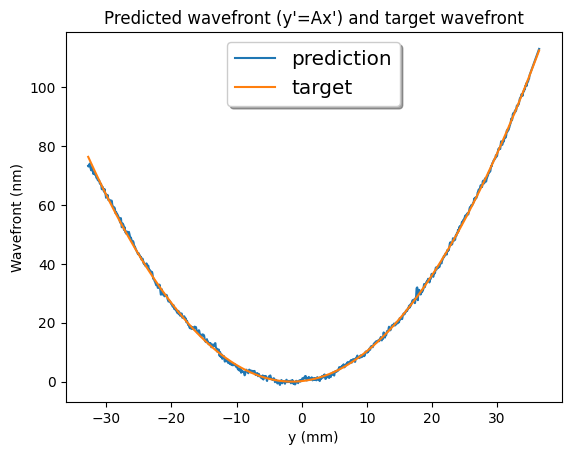

In [13]:
# find the solution by using Ax = y, x = A^-1 * y 
solution_V = np.dot(np.linalg.pinv(influence_waves_extend_umpV),wavefront_w)
solution_w = np.dot(influence_waves_extend_umpV,solution_V)

plt.plot(y_mm, solution_w*1e9, label ="prediction")
plt.plot(y_mm, wavefront_w*1e9, label="target")
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Predicted wavefront (y'=Ax') and target wavefront")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")
plt.show()

solution_V [ 1.45964762e-04 -4.48839832e-06  1.42437402e-06 -1.29143151e-04
  3.52730731e-06  2.47534615e-07  3.55564634e-06 -7.61685960e-08
  4.59688503e-06 -2.65032150e-06  4.39973458e-06 -1.21245592e-06
  2.65916085e-06  2.62428876e-06 -5.22535191e-07  4.76145941e-06
  4.16342068e-05  2.54057094e-06]


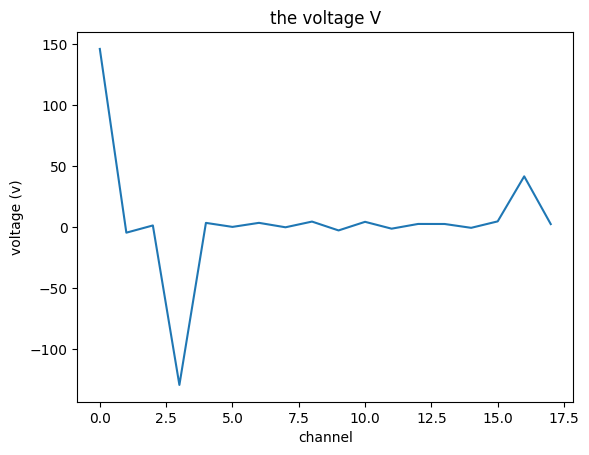

In [14]:
# plot the solution voltage
print("solution_V",solution_V)

plt.plot(solution_V[:18]*1e6)
plt.title("the voltage V")
plt.xlabel("channel")
plt.ylabel("voltage (v)")
plt.show()

Text(0, 0.5, 'Wavefront nm)')

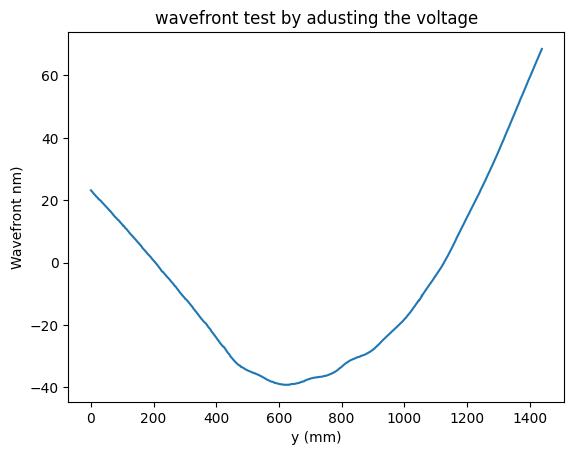

In [15]:
#modify the voltage to see the effect
solution_V2 = np.copy(solution_V)
solution_V2[0] = 0 #--> is not connected, null influence function
solution_V2[3] = 0
solution_V2[16] = 0 #--> pure tilt term
#plt.plot(np.dot(h,solution_V2))
solution_nm = np.dot(influence_waves_extend_umpV,solution_V)*1e9
plt.plot(np.dot(influence_waves_extend_umpV,solution_V2)*1e9)
plt.title("wavefront test by adusting the voltage")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront nm)")
#plt.plot(solution_V*1e6)

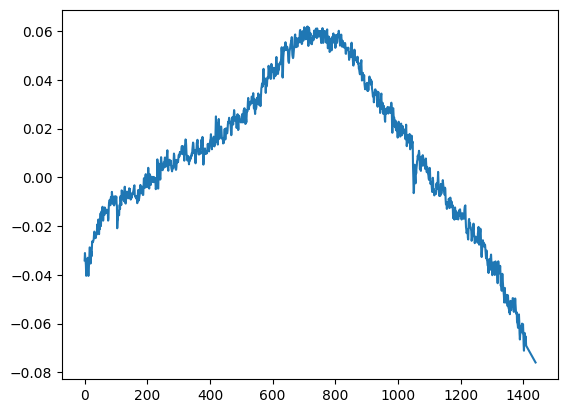

In [16]:
plt.plot(influence_waves_extend_umpV[:,3]*1e3)   

(1440, 13)


Text(0, 0.5, '(um/10V)')

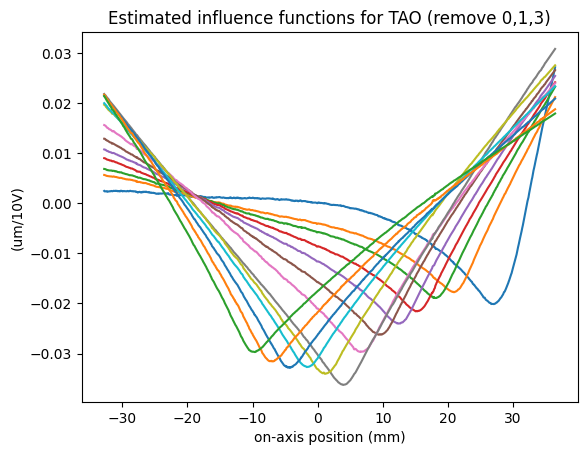

In [17]:
# remove index= 0,1, and 3 (bad cells)
fig,ax = plt.subplots()
xaxis = np.linspace(-40,40,influence_waves_3D_pV.shape[2])
interp_start = 1560
interp_end = 1630

crop_start = 150
crop_end = 1590
influence_waves_cleaned_pV=[]
for i in range(influence_waves_3D_pV.shape[0]):
    if i==0 or i==1 or i==3:
        continue
    #calculate the average of the all rows     
    each_yaxis_avg_um = np.mean(influence_waves_3D_pV[i,:,:], axis = 0)

    # interpolate the values between the start and end
    idx = np.arange(len(each_yaxis_avg_um))
    mask =  (idx<interp_start) | (idx>interp_end)
    data_cleaned_um = np.interp(idx,idx[mask],each_yaxis_avg_um[mask])

    #remove the leftmost and rightmost points
    influence_waves_cleaned_pV.append(data_cleaned_um[crop_start:crop_end])
    plt.plot(xaxis[crop_start:crop_end],data_cleaned_um[crop_start:crop_end])

influence_waves_cleaned_umpV = np.array(influence_waves_cleaned_pV).transpose((1,0))/10
print(influence_waves_cleaned_umpV.shape)
plt.title("Estimated influence functions for TAO (remove 0,1,3)")
plt.xlabel("on-axis position (mm)")
plt.ylabel("(um/10V)")

Text(0, 0.5, '(um/1V)')

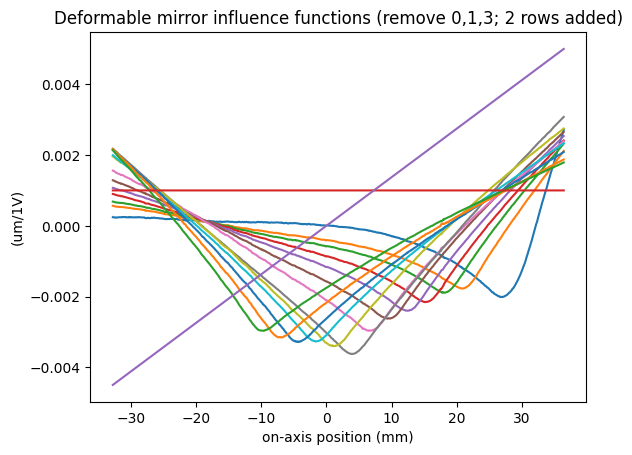

In [18]:
# add 2 rows to the influence function
c,d = np.shape(influence_waves_cleaned_umpV)
row3 = np.zeros((c,1))+0.001
row4 = y_mm/np.max(y_mm)*0.005


influence_waves_cleaned_extend_umpV = np.concatenate((influence_waves_cleaned_umpV,row3),axis=1)
influence_waves_cleaned_extend_umpV = np.concatenate((influence_waves_cleaned_extend_umpV,row4),axis=1)

plt.plot(y_mm, influence_waves_cleaned_extend_umpV)
plt.title("Deformable mirror influence functions (remove 0,1,3; 2 rows added)")
plt.xlabel("on-axis position (mm)")
plt.ylabel("(um/1V)")

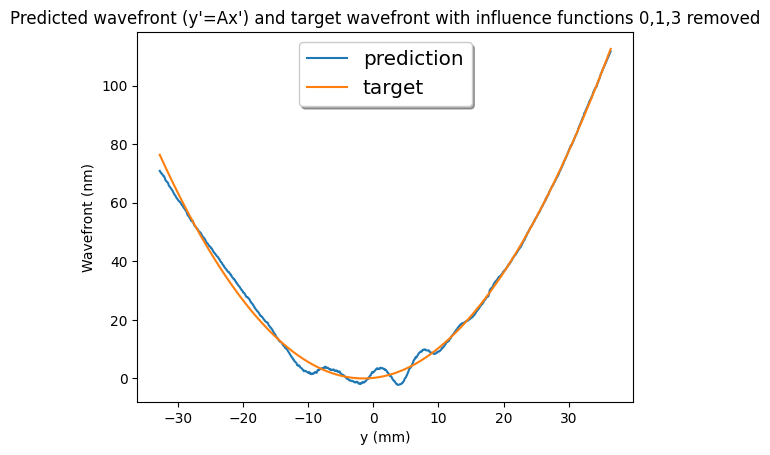

In [19]:
# plot the target and predicted wavefront shape
solution_V = np.dot(np.linalg.pinv(influence_waves_cleaned_extend_umpV),wavefront_w)
solution_w = np.dot(influence_waves_cleaned_extend_umpV,solution_V)

plt.plot(y_mm, solution_w*1e9, label ="prediction")
plt.plot(y_mm, wavefront_w*1e9, label="target")
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Predicted wavefront (y'=Ax') and target wavefront with influence functions 0,1,3 removed")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")
plt.show()

np.save("seg3A_cells_1-18_targetwave_m.npy",wavefront_w)
np.save("seg3A_cells_1-18_predictwave_m.npy",solution_w)

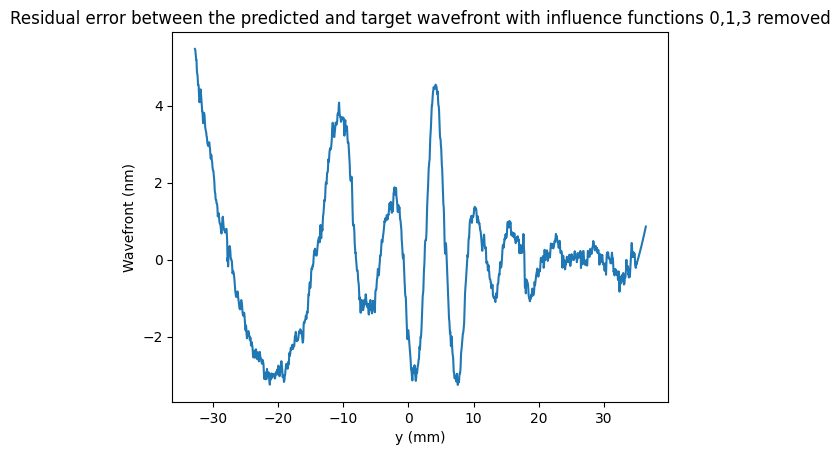

In [20]:
#plot the residual error
plt.plot(y_mm, (wavefront_w-solution_w)*1e9)
plt.title("Residual error between the predicted and target wavefront with influence functions 0,1,3 removed")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")
plt.show()

In [22]:
# calculate the rms std
rms_nm = np.std((wavefront_w-solution_w)*1e9)
print("rms error (nm)",rms_nm)

rms error (nm) 1.8269940375724638


cell 2 voltage: 1.7356706380963196
cell 4 voltage: 3.492415249849101
cell 5 voltage: -2.858882733331729
cell 6 voltage: 6.739277685678097
cell 7 voltage: -5.8714874830865025
cell 8 voltage: 12.886623160575988
cell 9 voltage: -17.360995540833017
cell 10 voltage: 23.309630053439314
cell 11 voltage: -16.86182182595745
cell 12 voltage: 10.966307244762389
cell 13 voltage: 0.1461315890798358
cell 14 voltage: -5.386785295413941
cell 15 voltage: 10.638676838109008
cell 16 voltage: 40.57238996970971
cell 17 voltage: 2.2899796391150087


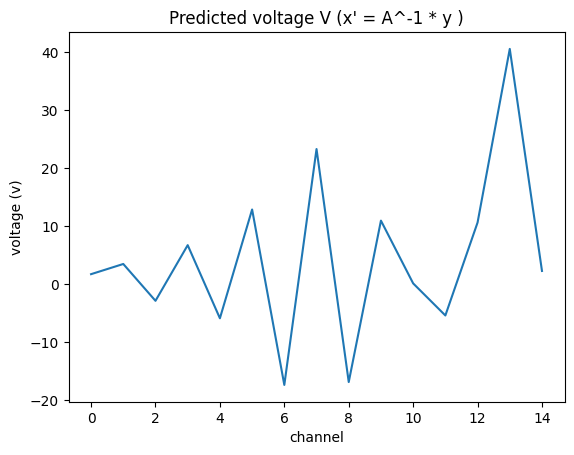

In [23]:
# plot the solution voltage
index =[2,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

for i in range(len(index)):
    print("cell "+str(index[i])+ " voltage:",solution_V[i]*1e6)

plt.plot(solution_V*1e6)
plt.title("Predicted voltage V (x' = A^-1 * y )")
plt.xlabel("channel")
plt.ylabel("voltage (v)")
plt.show()

In [24]:
#insert NAN values to bad cells
print(solution_V*1e6)

solution_18 = np.insert(solution_V*1e6,0,np.nan)
solution_18 = np.insert(solution_18,0,np.nan)
solution_18 = np.insert(solution_18,3,np.nan)

np.save("seg3A_cells_1-18_volts.npy", solution_18)
print(solution_18.shape)

[  1.73567064   3.49241525  -2.85888273   6.73927769  -5.87148748
  12.88662316 -17.36099554  23.30963005 -16.86182183  10.96630724
   0.14613159  -5.3867853   10.63867684  40.57238997   2.28997964]
(18,)


[         nan          nan   1.73567064          nan   3.49241525
  -2.85888273   6.73927769  -5.87148748  12.88662316 -17.36099554
  23.30963005 -16.86182183  10.96630724   0.14613159  -5.3867853
  10.63867684  40.57238997   2.28997964]


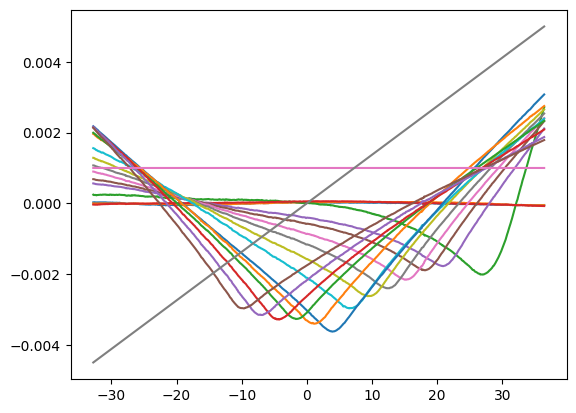

In [144]:
#read the saved files and check the data
ifs = np.load("seg3A_cells_1-18_ifs.npy")
volts=np.load("seg3A_cells_1-18_volts.npy")
print(volts)
plt.plot(y_mm, ifs)

Text(0, 0.5, 'Wavefront (nm)')

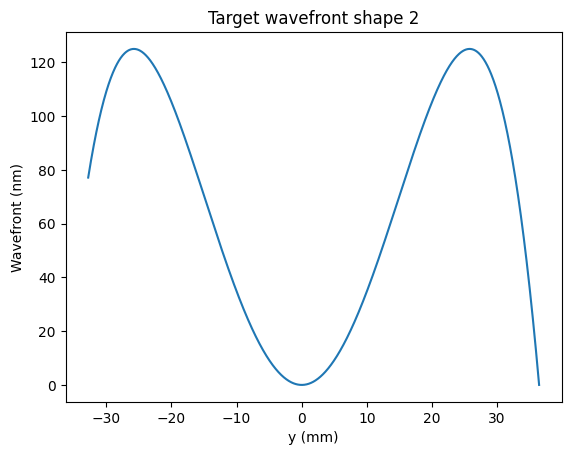

In [25]:
#define a 2nd target wavefront shape and repeat the process
target_shape_m = (((idx-800)/np.max(idx))**2)*100e-9*5


###
yc_mm = 10
target_shape_m = (((y_mm-yc_mm)/np.max(y_mm))**2)*100e-9*5
wavefront_w = target_shape_m
###

yc_mm = 0
target_shape_m = (((y_mm-yc_mm)/np.max(y_mm))**2-((y_mm-yc_mm)/np.max(y_mm))**4)*100e-9*5
wavefront_w = target_shape_m


plt.plot(y_mm,wavefront_w*1e9)
plt.title("Target wavefront shape 2")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")

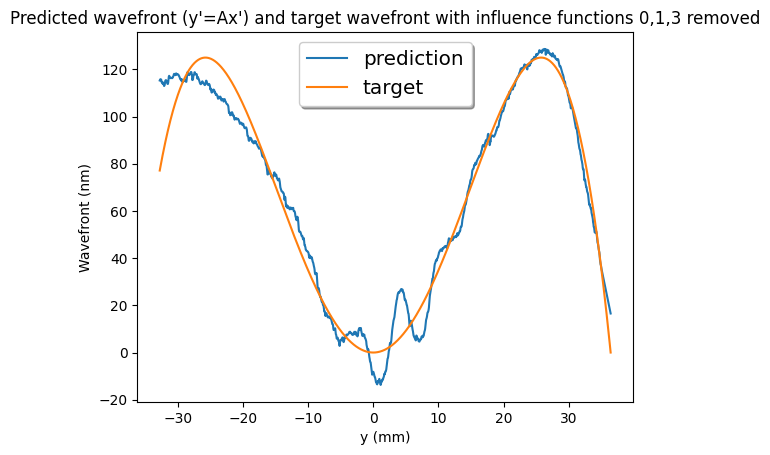

In [28]:
# calculate the solution and plot the predicted and target wavefront shape
solution_V = np.dot(np.linalg.pinv(influence_waves_cleaned_extend_umpV),wavefront_w)
solution_w = np.dot(influence_waves_cleaned_extend_umpV,solution_V)

plt.plot(y_mm, solution_w*1e9, label ="prediction")
plt.plot(y_mm, wavefront_w*1e9, label="target")
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Predicted wavefront (y'=Ax') and target wavefront with influence functions 0,1,3 removed")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")
plt.show()

np.save("seg3A_cells_1-18_targetwave2_m.npy",wavefront_w)
np.save("seg3A_cells_1-18_predictwave2_m.npy",solution_w)

In [30]:
# insert NAN values to bad cells
print(solution_V*1e6)

solution_18 = np.insert(solution_V,0,np.nan)
solution_18 = np.insert(solution_18,0,np.nan)
solution_18 = np.insert(solution_18,3,np.nan)

np.save("seg3A_cells_1-18_volts2.npy", solution_18)
print(solution_18)

[[-20.99738214]
 [-12.79318253]
 [ 15.40606902]
 [-27.32754874]
 [ 41.28883657]
 [-52.15048374]
 [ 89.70288334]
 [-91.15936315]
 [ 87.23967346]
 [-40.37000281]
 [ 19.69211385]
 [ 10.69335657]
 [-11.57227777]
 [ 69.18837945]
 [ -5.03395003]]
[            nan             nan -2.09973821e-05             nan
 -1.27931825e-05  1.54060690e-05 -2.73275487e-05  4.12888366e-05
 -5.21504837e-05  8.97028833e-05 -9.11593631e-05  8.72396735e-05
 -4.03700028e-05  1.96921139e-05  1.06933566e-05 -1.15722778e-05
  6.91883795e-05 -5.03395003e-06]


[            nan             nan -2.09973821e-05             nan
 -1.27931825e-05  1.54060690e-05 -2.73275487e-05  4.12888366e-05
 -5.21504837e-05  8.97028833e-05 -9.11593631e-05  8.72396735e-05
 -4.03700028e-05  1.96921139e-05  1.06933566e-05 -1.15722778e-05
  6.91883795e-05 -5.03395003e-06]


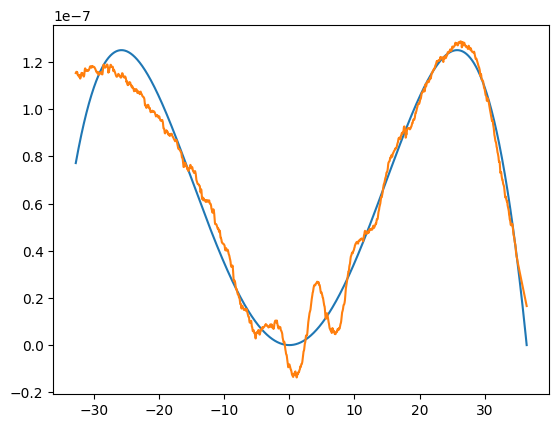

In [39]:
# load the saved files and check the data
volts=np.load("seg3A_cells_1-18_volts2.npy")
target=np.load("seg3A_cells_1-18_targetwave2_m.npy")
pre=np.load("seg3A_cells_1-18_predictwave2_m.npy")
print(volts)
plt.plot(y_mm, target)
plt.plot(y_mm, pre)


Text(0, 0.5, 'Wavefront (nm)')

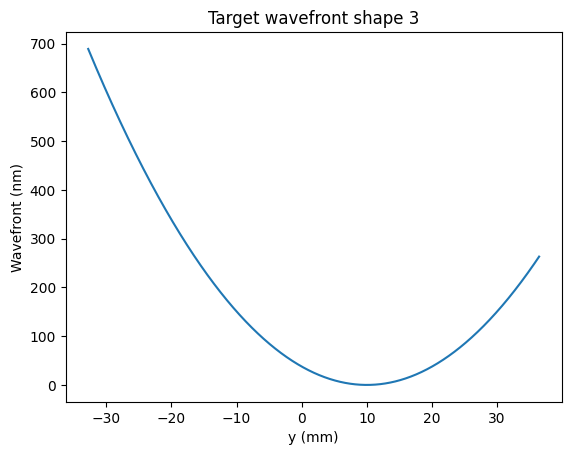

In [31]:
#define a 3rd target wavefront shape
target_shape_m = (((idx-800)/np.max(idx))**2)*100e-9*5


###
yc_mm = 10
target_shape_m = (((y_mm-yc_mm)/np.max(y_mm))**2)*100e-9*5
wavefront_w = target_shape_m
###




plt.plot(y_mm,wavefront_w*1e9)
plt.title("Target wavefront shape 3")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")

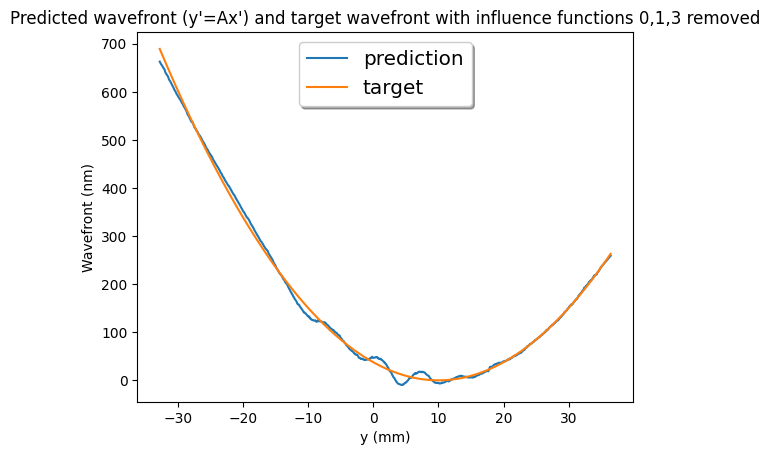

In [32]:
# calculate the solution and plot the predicted and target wavefront shape
solution_V = np.dot(np.linalg.pinv(influence_waves_cleaned_extend_umpV),wavefront_w)
solution_w = np.dot(influence_waves_cleaned_extend_umpV,solution_V)

plt.plot(y_mm, solution_w*1e9, label ="prediction")
plt.plot(y_mm, wavefront_w*1e9, label="target")
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Predicted wavefront (y'=Ax') and target wavefront with influence functions 0,1,3 removed")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")
plt.show()

np.save("seg3A_cells_1-18_targetwave3_m.npy",wavefront_w)
np.save("seg3A_cells_1-18_predictwave3_m.npy",solution_w)

In [33]:
# insert NAN values to bad cells
print(solution_V*1e6)

solution_18 = np.insert(solution_V,0,np.nan)
solution_18 = np.insert(solution_18,0,np.nan)
solution_18 = np.insert(solution_18,3,np.nan)

np.save("seg3A_cells_1-18_volts3.npy", solution_18)
print(solution_18)

[[  8.3653967 ]
 [ 16.83236345]
 [-13.77893228]
 [ 32.48123814]
 [-28.29875723]
 [ 62.10954574]
 [-83.67463944]
 [112.34522154]
 [-81.26877622]
 [ 52.85421579]
 [  0.70430915]
 [-25.96264231]
 [ 51.27513837]
 [232.33561288]
 [-52.16432515]]
[            nan             nan  8.36539670e-06             nan
  1.68323635e-05 -1.37789323e-05  3.24812381e-05 -2.82987572e-05
  6.21095457e-05 -8.36746394e-05  1.12345222e-04 -8.12687762e-05
  5.28542158e-05  7.04309151e-07 -2.59626423e-05  5.12751384e-05
  2.32335613e-04 -5.21643252e-05]


[            nan             nan  8.36539670e-06             nan
  1.68323635e-05 -1.37789323e-05  3.24812381e-05 -2.82987572e-05
  6.21095457e-05 -8.36746394e-05  1.12345222e-04 -8.12687762e-05
  5.28542158e-05  7.04309151e-07 -2.59626423e-05  5.12751384e-05
  2.32335613e-04 -5.21643252e-05]


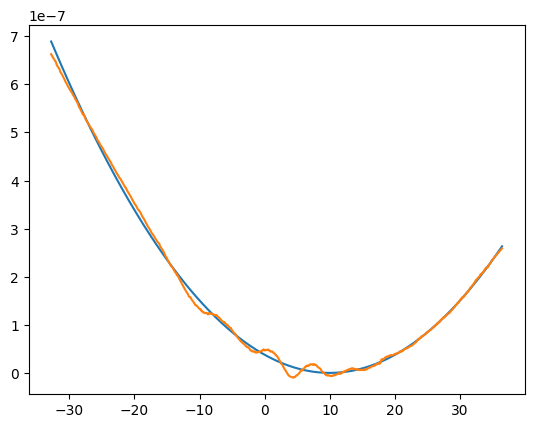

In [40]:
# load the saved files and check the data
volts=np.load("seg3A_cells_1-18_volts3.npy")
target=np.load("seg3A_cells_1-18_targetwave3_m.npy")
pre=np.load("seg3A_cells_1-18_predictwave3_m.npy")
print(volts)
plt.plot(y_mm, target)
plt.plot(y_mm, pre)

# 3 compare with the influence function collected at argone nation lab

Text(0.5, 0, 'on-axis position (mm)')

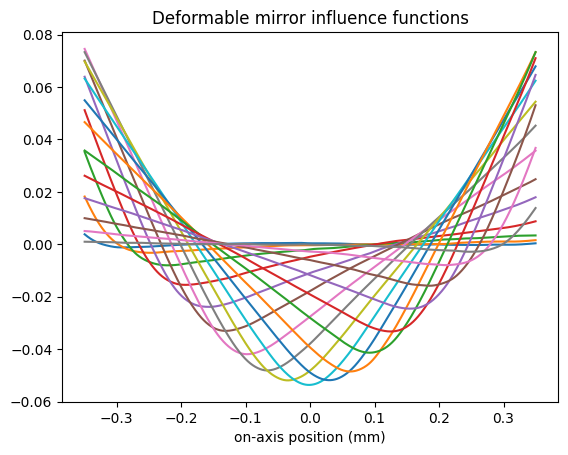

In [28]:
# change here!
file_name = "../task7_monoplus_4th/axo_jtec_aps_influence.mat"

# load the data
data = sc.loadmat(file_name)

#Extracting data from the file
datay_m = data["y_m"]
datainfluence_waves_pV = data["infFn_w"]

#Removing the nan data
noNAN = np.isfinite(datainfluence_waves_pV)
rinfluence_waves_pV = np.array(datainfluence_waves_pV[noNAN])

#Reshaping the array
influence_waves_pV2 = np.reshape(rinfluence_waves_pV, (1077, 18)) 

y_m2 = datay_m[742:1819]

plt.plot(y_m2*1e3, influence_waves_pV2[:,:])
plt.title("Deformable mirror influence functions")
plt.xlabel("on-axis position (mm)")